In [93]:
import random

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd

import math

from util import *

In [94]:
def terminal(state, k_eps=1e-4):
    for i in state.flatten():
        if abs(i) <= k_eps:
            return True
    return False

class Node:
    def __init__(self, parent, state, n_children, value, depth=0):
        self.state = state
        self.parent = parent
        self.visits = 0
        self.depth = depth
        self.children = [None] * n_children
        self.is_terminal = terminal(self.state)
        self.value = value
        self.subtree_value = torch.zeros(1)

    def __str__(self):
        return ("State: " + str(self.state) + "; Value: " + str(self.value)
                + "; Subtree Value: " + str(self.subtree_value) + "; Visits:", str(self.visits))

    def is_leaf(self):
        for i in self.state:
            if i is not None:
                return False
        return True


In [95]:
class MCTS:
    def __init__(self, actions, C, weight, value_fn):
        self.actions = actions
        self.k_C = C
        self.k_weight = weight
        self.value_fn = value_fn
        self.max_depth = 0
        self.terminal = None    # None if no terminal state found; terminal Node if found
        self.root = None

    def pick_child(self, node):
        # UCT
        t = []
        for i in node.children:
            if i is None:
                continue
            t.append(UCT_fn(i, self.k_C))

        t = torch.tensor(t)

        rvs = torch.squeeze(torch.argwhere(t == torch.max(t)), axis=1)
        if len(rvs) == 0:
            return random.randint(0, len(node.children)-1)
        return int(random.choice(rvs))

    def default_search(self, node):
        """
        If node is fully explored (neither child is None), return True
        Otherwise, initialize value of a random unexplored next state

        :param node: node to search from
        :return: if fully explored, True. Else, value of the random unexplored next state
        """
        possible = []
        for i in range(len(node.children)):
            if node.children[i] is None:
                possible.append(i)
        if len(possible) == 0:
            return True

        i = random.choice(possible)
        # if unexplored or non-terminal, get value
        state = torch.tensor(self.actions[i](node.state.flatten()), dtype=torch.float)
        state = state.reshape(node.state.shape)
        # child_val = self.value_fn(state) - node.depth - 1  # give penalty -1 for each additional step taken
        child_val = self.value_fn(state)
        child_val = child_val.flatten()[0]
        node.children[i] = Node(node, state, len(self.actions), value=child_val, depth=node.depth+1)

        # if new Node is terminal, take it as the tree's terminal if it takes less time to reach than current terminal
        # if node.children[i].is_terminal:
        #     # if terminal, add reward of ||start_vec||_2^2
        #     node.children[i].value += torch.linalg.vector_norm(torch.square(self.root.state)).item()
        #     if self.terminal is None or node.children[i].depth < self.terminal.depth:
        #         self.terminal = node.children[i]

        if node.children[i].depth > self.max_depth:
            self.max_depth = node.children[i].depth
        return node.children[i]

    def tree_policy(self, node, computations):
        while node.is_terminal is False:
            explored = self.default_search(node)
            if explored is not True:
                return explored, computations + 1
            node = node.children[self.pick_child(node)]
            # node = random.choice(node.children)
        return node, computations + 1

    def mean_prop(self, node):
        """
        Backprop up from a leaf, where subtree_value is the average of a node's rewards and its subtree's rewards

        :param node: of subtree
        """
        node.subtree_value = torch.zeros(1)
        node.subtree_value += node.value
        valid_children = 0
        if not node.is_leaf():
            for i in node.children:
                if i is None:
                    continue
                node.subtree_value += self.k_weight * i.subtree_value
                valid_children += 1
        node.subtree_value /= valid_children + 1
        node.visits += 1
        if node.parent is None:
            return
        self.mean_prop(node.parent)

    def run(self, root, comp_limit=10):
        """
        Shoutout "A Survey of MCTS Methods"
        :param root: the current state
        :param comp_limit: max number of possible future scenarios to compute (carries over)
        :return: index corresponding to best action
        """
        self.root = root
        if self.root.is_terminal:
            return True
        comps = 0
        while comps < comp_limit:
            node, comps = self.tree_policy(self.root, comps)
            self.mean_prop(node)

        rv = self.pick_child(self.root)
        
        if False:
            print("root state:", root.state)
            print("child states: ",end="")
            for child in root.children:
                print(child.state, end=",")
            print()
        return rv

In [96]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.v_loss_fn = torch.nn.MSELoss()
        self.p_loss_fn = torch.nn.CrossEntropyLoss()
        
    def forward(self, v_out, v_target, p_out, p_target):
        """
        Loss function designed to reward successful game completion while taking the least amount of steps possible
        Adapted from:
            - "Mastering the game of Go without human knowledge" (Silver et al)
            - "Discovering faster matrix multiplication algorithms with reinforcement learning" (Fawzi et al)

        :param v_out: the value outputed for the state by NN
        :param p_out: the policy outputed for the state by NN
        :param v_target: target value output
        :return: total loss
        """
        loss = self.v_loss_fn(v_out, v_target)
        loss += self.p_loss_fn(p_out, p_target)
        return loss


        
class ValueNN(nn.Module):
    def __init__(self):
        super(ValueNN, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        self.value_activation = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.stack(x).flatten()
        # value = self.value_activation(x[0:1]).unsqueeze(0)
        value = x[0:1].reshape((1,1))
        return value


class PolicyNN(nn.Module):
    def __init__(self, n_actions):
        super(PolicyNN, self).__init__()
        self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, n_actions),
        )
        self.policy_activation = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.policy_activation(self.stack(x).flatten())
        # value = self.value_activation(x[0:1]).unsqueeze(0)
        policy = torch.clamp(x.unsqueeze(0),min=1e-8,max=1-(1e-8))
        return policy

In [97]:
import math

k_C = 1 / math.sqrt(2)

loss_fn = Loss()

def train(epochs, actions, policy_fn, value_fn, optimizers, rand_start_state_fn, comp_limit):
    for t in range(epochs):
        for o in optimizers:
            o.zero_grad()
        # Repeat the following:
        # 1) run the NN on some random initial state
        # 2) update the NN based off performance in that game
        mcts = MCTS(actions, C=k_C, weight=1, value_fn=value_fn)
        start = rand_start_state_fn()

        value = mcts.value_fn(start).flatten()
        policy = policy_fn(start).flatten()

        start_node = Node(None, start, len(actions), value, 0)

        # play out a game
        mcts.run(start_node, comp_limit=comp_limit)

        # get attributes of game just played
        v_out = start_node.subtree_value
        v_target = -mcts.max_depth
        if mcts.terminal is not None:
            v_target = -mcts.terminal.depth + torch.linalg.norm(start)

        visits = []
        for i in start_node.children:
            if i is None:
                visits.append(0)
            else:
                visits.append(i.visits)
        visits = torch.tensor(visits, dtype=torch.float)
        p_sampled = visits / torch.sum(visits)
        
        loss = loss_fn(v_out, torch.tensor(v_target,dtype=v_out.dtype), policy.flatten(), p_sampled.flatten())
        loss.backward()
        for o in optimizers:
            o.step()

        if (t+1) % 10 == 0:
            print("Epoch:", t+1,"\t\tLoss:",loss.item())

In [98]:
k_comp_limit = int(k_state_upper_lim ** (3/2))
k_2actions = (a_subtract, a_swap)
value_fn_2 = ValueNN()
policy_fn_2 = PolicyNN(len(k_actions))
value_optim = optim.Adam(value_fn_2.parameters(), lr=0.0001)
policy_optim = optim.Adam(policy_fn_2.parameters(), lr=0.0001)
k_state_upper_lim = 30 # arbitrary

def gen_start_state_2a():
    limit = k_state_upper_lim
    return torch.round(torch.rand((1, 2)) * limit + 1).float()

train(epochs=100, actions=k_2actions, policy_fn=policy_fn_2, value_fn=value_fn_2, optimizers=[value_optim, policy_optim], rand_start_state_fn=gen_start_state_2a, comp_limit=k_comp_limit)

Epoch: 10 		Loss: 65.8193130493164
Epoch: 20 		Loss: 42.127017974853516
Epoch: 30 		Loss: 59.532718658447266
Epoch: 40 		Loss: 48.38131332397461
Epoch: 50 		Loss: 29.40606689453125
Epoch: 60 		Loss: 44.74832534790039
Epoch: 70 		Loss: 24.35161590576172
Epoch: 80 		Loss: 25.03790855407715
Epoch: 90 		Loss: 3.6419973373413086
Epoch: 100 		Loss: 5.68751859664917


In [34]:
save = False
if save:
    torch.save(value_fn.state_dict(), "deep_mcts_v_weights.pth")
    torch.save(policy_fn.state_dict(), "deep_mcts_p_weights.pth")

In [99]:
def get_data(fname):
    x = torch.tensor(np.loadtxt(fname, delimiter=","), dtype=torch.float)
    return x[:,:-1], x[:,-1]

def plot_db(policy_fn, actions, comp_limit, ranges):
    X = ranges[0]
    Y = ranges[1]
    action_plot = []
    for i in actions:
        action_plot.append([])
    for i in X:
        for j in Y:
            rv = policy_fn(torch.tensor([i,j],dtype=torch.float).reshape(1,len(actions)))
            action_plot[torch.argmax(rv)].append((i,j))
    for i in range(len(action_plot)):
        action = np.array(action_plot[i])
        plt.scatter(action[:,0], action[:,1], color=("C"+str(i)), label=action)
    plt.show()

In [100]:
def test(x, y, C, policy_fn, weight=1., comp_limit=10, actions=(a_subtract, a_swap), zero_index=False, dbs=None):
    correct = 0
    mcts = MCTS(actions, C, weight, value_fn)
    guess_dist = [0] * len(actions)
    if zero_index:
        y = y - np.ones(len(y))
    for i in range(len(x)):
        state = torch.tensor(x[i]).unsqueeze(0)
        rv = policy_fn(state).flatten()                      # take the move distribution given by NN

        # todo pick one way to select
        # rv = rv.multinomial(num_samples=1, replacement=True)    # sample from the move distribution
        rv = torch.argmax(rv)

        if rv == y[i]:
            correct += 1
        guess_dist[rv] += 1
    # todo fix
    if dbs is not None:
        # graphing decision boundary
        plot_db(policy_fn, actions, comp_limit, ranges=dbs)
    return correct / len(x), guess_dist


def run_test(data_name, actions, C, policy_fn, cases=100, lookahead=100, weight=1., zero_index=False, dbs=None):
    test_X, test_Y = get_data(data_name)
    test_Y.reshape(-1, 1)

    acc, guesses = test(test_X[:cases], test_Y[:cases],
                        C, policy_fn, weight, comp_limit=lookahead, actions=actions, zero_index=zero_index, dbs=dbs)
    print("Test Accuracy:", acc)
    print("Guess Distribution:", guesses)


/var/folders/t9/gxb6q8zj21dff090q066td740000gn/T/ipykernel_2763/1594351740.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(x[i]).unsqueeze(0)


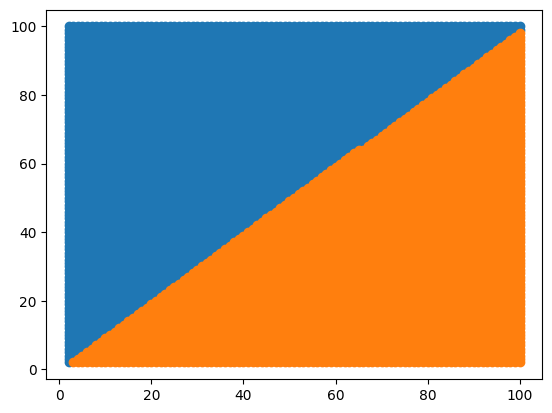

Test Accuracy: 0.9905
Guess Distribution: [1039, 961]


In [101]:
k_cases = 2000
k_dbound_size = 100

dual_file = "test_data/test_simple.csv"

db2 = np.linspace(2, k_dbound_size, k_dbound_size - 1)
two_dbs =[db2, db2]

run_test(dual_file, [a_subtract, a_swap], C=k_C, policy_fn=policy_fn, cases=k_cases, lookahead=10, dbs=two_dbs)
# ~99% accuracy

In [ ]:
# quad_file = "../Donald/four_step_euclidean/four_directions_cleaner_test.csv"     # thanks, donald

# k_C = 1 / math.sqrt(2)  # satisfies Hoeffding Ineq (Kocsis and Szepesvari)
# k_cases = 10

# k_dbound_size = 100

# db4 = np.linspace(-k_dbound_size/2, k_dbound_size/2, k_dbound_size+1)
# quad_dbs = [db4, db4]
# run_test(quad_file, [a_plsy, a_suby, a_plsx, a_subx], k_C, k_cases, lookahead=100, zero_index=False)
# # 8% accuracy on Donald test csv